In [1]:
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as special
import scipy.integrate as integrate
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import math
from tqdm import tqdm
from utils import generate_n_random_numbers

## Task 1

Исследование доверительных интервалов для MAD

In [2]:
P = 0.95
PERCENTILE = ((1 - P) / 2) * 100
norm_quantile = sps.norm(loc=0, scale=1).ppf((1 + P) / 2)
ANALYTICAL_EXPECTATION = 0
ANALYTICAL_MEDIAN = 0
ITERATIONS = 10 ** 4
BOOTSTRAP_SIZE = 1000
DISTROS = ["Uniform[-1, 1]", "Norm(0, 1)", "2xUniform[-1, 1]"]
# NS = [10, 100, 500]
min_sample_size = 20
max_sample_size = 500
num_of_sample_sizes = 4
BASE = 5
# NS = list(map(int, np.linspace(min_sample_size, max_sample_size, num_of_sample_sizes)))
NS = list(map(int, np.logspace(base=BASE, start=math.log(min_sample_size, BASE), stop=math.log(max_sample_size, BASE), num=num_of_sample_sizes)))
print(NS)

[20, 58, 170, 500]


In [3]:
ANALYTICAL_MADS = {d: 0.0 for d in DISTROS}

Для того чтобы оценить, сколько доверительных интервалов на самом деле содержат реальные MAD, нужно их сначала найти для наших распределений.
Мы знаем, что
$$\text{MAD}(X) = \text{median}(|X-\text{median}(X)|)$$
Поскольку для каждого из наших распределений медиана равна нулю, то
$$\text{MAD}(X) = \text{median}(|X|)$$
Найти это легко для $\text{Uniform}[-1, 1]$, поскольку его модуль превращается просто в $\text{Uniform}[0, 1]$, а значит его $\text{MAD} = 0.5$.

In [4]:
ANALYTICAL_MADS["Uniform[-1, 1]"] = 0.5

Уже несколько сложнее для $\text{Norm}(0, 1)$. Найдём функцию распределения модуля стандартного нормального распределения. 
$$F_{|Norm(0, 1)|}(t) = \int_{-\infty}^t p_{|Norm(0, 1)|}(x)dx = \int_{-\infty}^t (p_{Norm(0, 1)}(x) + p_{Norm(0, 1)}(-x)) \cdot \mathbb{1}_{[0, +\infty)}(x) dx = 2 \cdot \int_{0}^t p_{Norm(0, 1)}(x) dx =$$
$$[t \geqslant 0] = 2 \cdot \left(\int_{-\infty}^t p_{Norm(0, 1)}(x) dx - \int_{-\infty}^0 p_{Norm(0,1)} dx\right) = 2\cdot (\Phi(t) - 0.5) = 2\Phi(t) - 1$$
в силу симметричности стандартного нормального распределения.

По определению, медиана $m: \; \mathbb{P}(\xi \leqslant m) = \frac{1}{2}$, то есть $F(m) = \frac{1}{2}$. Для модуля стандартного нормального распределения это $$2\Phi(m) - 1 = \frac{1}{2} \Rightarrow \Phi(m) = 0.75 \Rightarrow m \text{ - }75\%\text{-ая квантиль Norm}(0, 1).$$

In [5]:
ANALYTICAL_MADS["Norm(0, 1)"] = float(sps.norm.ppf(0.75, loc=0, scale=1))

Для $2\cdot \text{Uniform[-1, 1]}$ нужно найти функцию распределения модуля и по ней бинпоиском медиану. Для этого проинтегрируем свёртку плотностей равномерных распределений, то есть
$$\xi, \eta \sim \text{Uniform[-1, 1]}$$
$$F_{\xi + \eta}(t) = \int_{-\infty}^t p_{\xi + \eta}(x) dx = \int_{-\infty}^t \int_{\mathbb{R}} p_\xi(y)\cdot p_\eta(x-y)dy dx$$
Внутренний интеграл легко посчитать и аналитически записать полученную функцию. 

Чтобы получить плотность распределения $|2 \cdot \text{Uniform}[-1, 1]|$ в точке $t$, сложим плотности в точках $-t$ и $t$, при условии $0 \leqslant t$. Итого можем посчитать функцию распределения модуля суммы двух равномерных распределений:

In [6]:
def uniform_sum_pdf(t: float) -> float:
    if t <= -2 or t >= 2:
        return 0
    if -2 < t <= 0:
        return (2 + t) / 4
    return (2 - t) / 4

def uniform_sum_cdf(t):
    return integrate.quad(uniform_sum_pdf, -np.inf, t)[0]

def abs_uniform_sum_pdf(t):
    return uniform_sum_pdf(t) + uniform_sum_pdf(-t) if t >= 0 else 0

def abs_uniform_sum_cdf(t):
    return integrate.quad(abs_uniform_sum_pdf, -np.inf, t)[0]

In [7]:
def binary_search_median(cdf, lower_bound, upper_bound, tol=1e-6):
    while upper_bound - lower_bound > tol:
        mid = (lower_bound + upper_bound) / 2
        if cdf(mid) < 0.5:
            lower_bound = mid
        else:
            upper_bound = mid
    return (lower_bound + upper_bound) / 2

In [8]:
ANALYTICAL_MADS["2xUniform[-1, 1]"] = binary_search_median(abs_uniform_sum_cdf, 0, 2, tol=1e-10)

Визуализация для наглядности

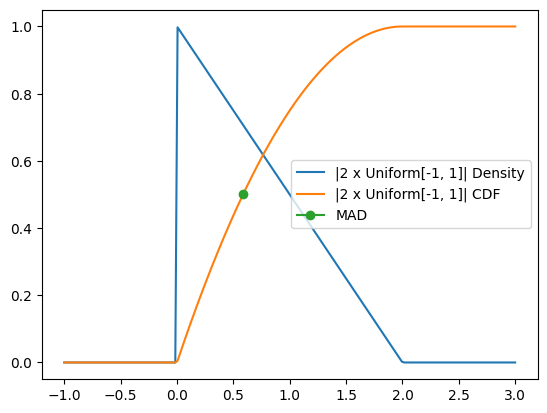

In [9]:
x = np.linspace(-1, 3, 200)
y1 = [abs_uniform_sum_pdf(t) for t in x]
y2 = [abs_uniform_sum_cdf(t) for t in x]
    
plt.plot(x, y1, label='|2 x Uniform[-1, 1]| Density')
plt.plot(x, y2, label='|2 x Uniform[-1, 1]| CDF')
plt.plot(ANALYTICAL_MADS["2xUniform[-1, 1]"], abs_uniform_sum_cdf(ANALYTICAL_MADS["2xUniform[-1, 1]"]), '-o', label='MAD')
plt.legend()
plt.show()

In [10]:
print(ANALYTICAL_MADS)

{'Uniform[-1, 1]': 0.5, 'Norm(0, 1)': 0.6744897501960817, '2xUniform[-1, 1]': 0.5857864380523097}


Функции подсчёта доверительного интервала для MAD (Median Absolute Deviation) в предположении нормализации закона распределения оценки MAD*. Для неё нам потребуется функция оценки медианы, оценки MAD и подсчёта среднеквадратичного отклонения методом bootstrap. 

In [11]:
def median_estimate(sample):
    n = len(sample)
    sample = sorted(sample)
    return sample[(n + 1) // 2] if n % 2 == 1 else (sample[n // 2] + sample[n // 2 + 1]) / 2

def mad_estimate(sample):
    med_x = median_estimate(sample)
    y = np.abs(np.array(sample) - med_x)
    return median_estimate(y)

def standard_deviation(X, target):
    return math.sqrt(sum([(x - target) ** 2 for x in X]) / len(X))

def standard_deviation_bootstrap_estimate(sample, statistic):
    bootstrap_estimates = [statistic(np.random.choice(sample, size=len(sample), replace=True)) for _ in range(BOOTSTRAP_SIZE)]
    return standard_deviation(X=bootstrap_estimates, target=statistic(sample))

In [12]:
def mad_confidence_interval_approx_1(sample):
    term = standard_deviation_bootstrap_estimate(sample, mad_estimate) * norm_quantile
    sample_mad = mad_estimate(sample)
    return (sample_mad - term, sample_mad + term)

Функция асимптотического подсчёта доверительного интервала для MAD. Потребуется функция подсчёта доверительного интервала для медианы с прошлой практики. 

In [13]:
def quantile_confidence_interval_exact(sample: list, p=0.5, return_indexes=False) -> tuple:
    def bernoulli_coef(n: int, m: int, p: float) -> float:
        return sps.binom.pmf(m, n, p)
    sample = sorted(sample)
    n = len(sample)
    prob = (1 - P) / 2
    m_1 = -1
    cum_sum_1 = 0
    while True:
        next_coef = bernoulli_coef(n, m_1 + 1, p)
        if cum_sum_1 + next_coef > prob:
            break
        cum_sum_1 += next_coef
        m_1 += 1
    m_2 = n + 1
    cum_sum_2 = 0
    while True:
        next_coef = bernoulli_coef(n, m_2 - 1, p)
        if cum_sum_2 + next_coef > prob:
            break
        cum_sum_2 += next_coef
        m_2 -= 1
    if return_indexes:
        return (sample[m_1] if m_1 >= 0 else -np.inf, sample[m_2] if m_2 <= n - 1 else np.inf, m_1, m_2)
    else:
        return (sample[m_1] if m_1 >= 0 else -np.inf, sample[m_2] if m_2 <= n - 1 else np.inf)

In [14]:
def mad_confidence_interval_asympt(sample):
    med_x = median_estimate(sample)
    y = np.abs(np.array(sample) - med_x)
    return quantile_confidence_interval_exact(sample=y, p=0.5)

Функция приблизительного подсчёта доверительного интервала для MAD номер 2.

In [15]:
def mad_confidence_interval_approx_2(sample):
    x_k_1, x_k_2, k_1, k_2 = quantile_confidence_interval_exact(sample, p=0.5, return_indexes=True)
    y_1 = np.minimum(np.abs(np.array(sample) - x_k_1), np.abs(np.array(sample) - x_k_2))
    y_2 = np.maximum(np.abs(np.array(sample) - x_k_1), np.abs(np.array(sample) - x_k_2))
    return (sorted(y_1)[k_1], sorted(y_2)[k_2])

Сгенерируем по $10^4$ выборок разных размеров для каждого распределения и проверим, какая доля из них будет попадать в доверительный интервал для MAD, посчитав доверительный интервал для этой доли.

In [16]:
methods = ["asympt", "approx_1", "approx_2"]
NUM_METHODS = len(methods)
methods_functions = {"asympt": mad_confidence_interval_asympt,
                     "approx_1": mad_confidence_interval_approx_1,
                     "approx_2": mad_confidence_interval_approx_2}

In [17]:
print("Start generating samples...")
samples = {d: [[generate_n_random_numbers(n, d) for _ in range(ITERATIONS)]
                for n in NS] for d in tqdm(DISTROS)}
print("Samples generated.")

Start generating samples...


100%|██████████| 3/3 [00:12<00:00,  4.23s/it]

Samples generated.


Теперь приступим к подсчёту доверительных интервалов для MAD

In [18]:
results = {d: {m + g: [] for m in methods for g in ['_intervals', '_points']} for d in DISTROS}
for i, d in enumerate(DISTROS):
    for n_id, n in enumerate(NS):
        print(f"Distribution {d}, samples size = {n}")
        for method in methods:
            print(f"    {method.capitalize()}:")
            hits_counter = 0
            for sample in tqdm(samples[d][n_id]):
                d_left, d_right = methods_functions[method](sample=sample)
                hits_counter += d_left <= ANALYTICAL_MADS[d] <= d_right
                
            results[d][method + "_intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
            results[d][method + "_points"].append(hits_counter / ITERATIONS)
    print('-' * 40)

Distribution Uniform[-1, 1], samples size = 20
    Asympt:


100%|██████████| 10000/10000 [00:08<00:00, 1148.53it/s]


    Approx_1:


100%|██████████| 10000/10000 [03:24<00:00, 48.97it/s]


    Approx_2:


100%|██████████| 10000/10000 [00:09<00:00, 1002.04it/s]


Distribution Uniform[-1, 1], samples size = 58
    Asympt:


100%|██████████| 10000/10000 [00:28<00:00, 352.70it/s]


    Approx_1:


 36%|███▋      | 3635/10000 [02:13<03:53, 27.28it/s]


KeyboardInterrupt: 

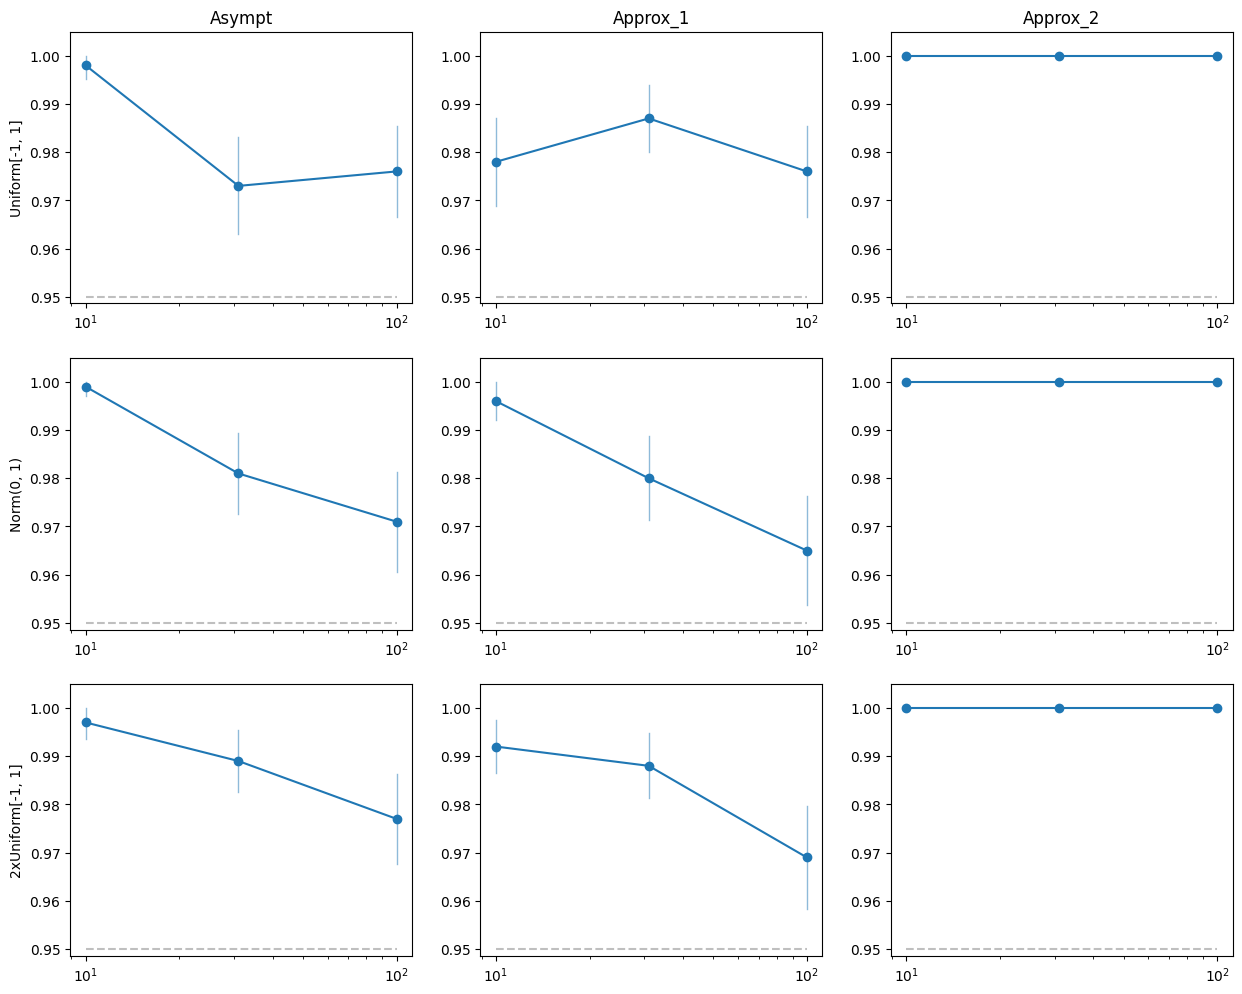

In [19]:
_, axis = plt.subplots(len(DISTROS), NUM_METHODS, figsize=(5 * NUM_METHODS, 4 * len(DISTROS)))
max_y, min_y = -np.inf, np.inf
for i, d in enumerate(DISTROS):
    for method_id, method in enumerate(methods):
        for interval_id, interval in enumerate(results[d][method + "_intervals"]):
            axis[i][method_id].plot([NS[interval_id]] * 2, list(interval), alpha=.5, linewidth=1, color='C0')
            max_y, min_y = max(max_y, interval[1]), min(min_y, interval[0])
        axis[i][method_id].plot(NS, results[d][method + "_points"], '-o', alpha=1, color='C0')         
        axis[i][method_id].plot(NS, [P] * len(NS), color='gray', alpha=.5, linestyle='--')         
        axis[i][method_id].set_xscale('log')
        axis[0][method_id].title.set_text(method.capitalize())
    axis[i][0].set_ylabel(d)
min_y = min(P, min_y)
for i in range(len(DISTROS)):
    for j in range(len(methods)):
        axis[i][j].set_ylim([min_y - 0.005, max_y + 0.005])
plt.show()

## Task 2

Проверим экспериментально достаточность вычисленного размера выборки необходимого для получения оценки математического ожидания (в случае известной дисперсии).

In [38]:
SIGMAS_SQUARED = {"Uniform[-1, 1]": 1 / 3,
                 "Norm(0, 1)": 1,
                 "2xUniform[-1, 1]": 2 / 3}
DELTAS = list(np.logspace(-1, -3, base=10, num = 3))
ITERATIONS = 10 ** 4
DELTAS

[np.float64(0.1), np.float64(0.01), np.float64(0.001)]

In [39]:
from functools import lru_cache

@lru_cache
def norm_quantile(p: float, loc=0, scale=1) -> float:
    return sps.norm.ppf(p, loc=loc, scale=scale)

def calculate_sufficient_sample_size(sigma_squared: float, delta: float, confidence_probability=P) -> int:
    return int(math.ceil(sigma_squared * pow(norm_quantile((1 + confidence_probability) / 2), 2) / delta))

In [40]:
def expectation_confidence_interval(sample, sigma_squared, confidence_probability=P):
    term = math.sqrt(sigma_squared / len(sample)) * norm_quantile((1 + confidence_probability) / 2)
    x_mean = np.mean(sample)
    return (x_mean - term, x_mean + term)

In [49]:
results_task_2 = {d: {g: [] for g in ['intervals', 'points']} for d in DISTROS}
for d_id, d in enumerate(DISTROS):
    for delta_id, delta in enumerate(DELTAS):
        deviation = SIGMAS_SQUARED[d]
        n = calculate_sufficient_sample_size(sigma_squared=deviation, delta=delta)
        print(f"Sufficient n for {d} and delta {delta} is {n}")
        hits_counter = 0
        for _ in range(ITERATIONS):
            a, b = expectation_confidence_interval(sample=generate_n_random_numbers(n, d), sigma_squared=deviation)
            hits_counter += a <= ANALYTICAL_EXPECTATION <= b
        results_task_2[d]["intervals"].append(proportion_confint(hits_counter, ITERATIONS, alpha=1 - P, method='normal'))
        results_task_2[d]["points"].append(hits_counter / ITERATIONS)

Sufficient n for Uniform[-1, 1] and delta 0.1 is 13
Sufficient n for Uniform[-1, 1] and delta 0.01 is 129
Sufficient n for Uniform[-1, 1] and delta 0.001 is 1281
Sufficient n for Norm(0, 1) and delta 0.1 is 39
Sufficient n for Norm(0, 1) and delta 0.01 is 385
Sufficient n for Norm(0, 1) and delta 0.001 is 3842
Sufficient n for 2xUniform[-1, 1] and delta 0.1 is 26
Sufficient n for 2xUniform[-1, 1] and delta 0.01 is 257
Sufficient n for 2xUniform[-1, 1] and delta 0.001 is 2561


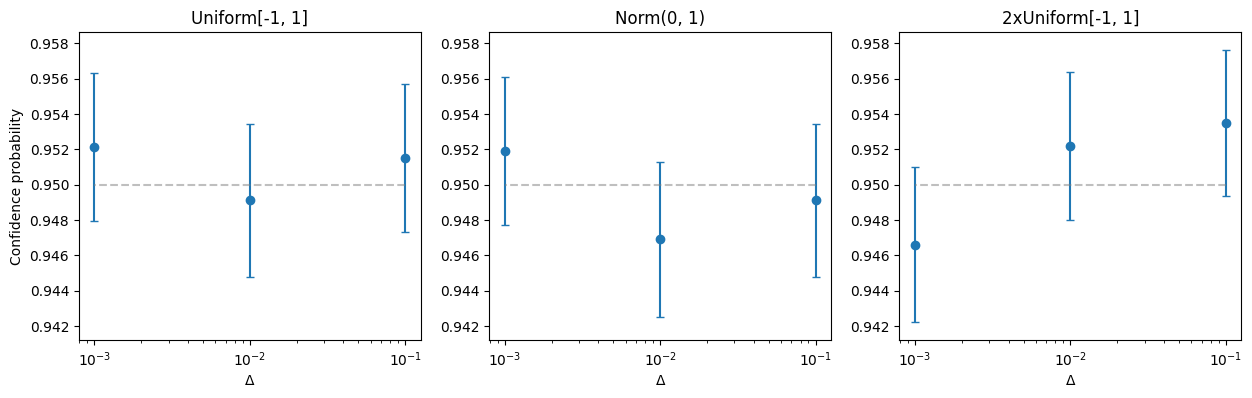

In [74]:
_, axis = plt.subplots(1, len(DISTROS), figsize=(5 * len(DISTROS), 4))
max_y, min_y = -np.inf, np.inf
y_error_min = []
for i, d in enumerate(DISTROS):
    y_error = list(map(lambda arr: np.abs(np.subtract(arr, results_task_2[d]['points'])), zip(*results_task_2[d]["intervals"])))
    axis[i].errorbar(DELTAS, results_task_2[d]["points"], yerr=y_error, fmt='o', capsize=3)
    axis[i].plot(DELTAS, [P] * len(NS), color='gray', alpha=.5, linestyle='--')   
    min_y = min(min_y, np.min(np.subtract(results_task_2[d]['points'], y_error[0])))
    max_y = max(max_y, np.max(np.add(results_task_2[d]['points'], y_error[1])))

axis[0].set_ylabel("Confidence probability")
for i, d in enumerate(DISTROS):
    axis[i].set_xscale('log')
    axis[i].set_xlabel('Δ')
    axis[i].title.set_text(f"{d}")
    axis[i].set_ylim([min(min_y, P) - 0.001, max_y + 0.001])